In [1]:
# TODO: separate train/val set and test set before preprocessing

In [1]:
import sys
import os
import datetime as dt
import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import random_split, DataLoader
from sklearn.metrics import precision_recall_fscore_support


# TODO: change path name
sys.path.append("/home/bchau/Math_156_temp/Final_Project/preprocessing/")
from preprocessing import EuroSATDataset

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [107]:
# TODO: change path name
# setting paths to EuroSAT data and preprocessing statistics
data_path = '/home/bchau/Math_156_temp/Final_Project/EuroSAT_RGB'
preprocessing_stats_path = '/home/bchau/Math_156_temp/Final_Project/preprocessing/preprocessing_stats.pkl'
checkpoint_path = '/home/bchau/Math_156_temp/Final_Project/checkpoints'

In [108]:
# getting eurosat dataset
eurosat = EuroSATDataset(data_path, preprocessing_stats_path, transform=True)
classes = eurosat.sorted_class_names

In [122]:
# splitting dataset into train, validation, and test
generator = torch.Generator().manual_seed(0)
train_val_set, test_set = random_split(eurosat, [0.8, 0.2], generator = generator)
train_set, val_set = random_split(train_val_set, [0.8, 0.2], generator = generator)

In [147]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 3)
        self.pooling = nn.MaxPool2d(2, 2)
        self.batch_norm = nn.BatchNorm2d(out_channels, track_running_stats=False)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.conv(x) 
        x = self.pooling(x)
        x = self.batch_norm(x) 
        x = self.relu(x) 
        return x

In [148]:
class FullyConnectedBlock(nn.Module):
    def __init__(self, in_channels, out_channels, is_output=False):
        super().__init__()
        self.is_output = is_output
        self.dense = nn.Linear(in_channels, out_channels)
        if not self.is_output:
            self.batch_norm = nn.BatchNorm1d(out_channels, track_running_stats=False)
            self.relu = nn.ReLU()

    def forward(self, x):
        x = self.dense(x)
        if not self.is_output: 
            x = self.batch_norm(x)
            x = self.relu(x)
        return x

In [153]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1 = ConvBlock(3, 8)
        self.conv_block2 = ConvBlock(8, 12)
        self.conv_block3 = ConvBlock(12, 16)
        flatten_channels = 16 * 6 * 6
        self.fc_block1 = FullyConnectedBlock(flatten_channels, flatten_channels // 2)
        self.fc_block2 = FullyConnectedBlock(flatten_channels // 2, flatten_channels // 2**2)
        self.fc_block3 = FullyConnectedBlock(flatten_channels // 2**2, flatten_channels // 2**3)
        self.fc_block4 = FullyConnectedBlock(flatten_channels // 2**3, 10, is_output=True)
        self.conv_blocks = nn.Sequential(
            self.conv_block1, 
            self.conv_block2, 
            self.conv_block3
        )
        self.fc_blocks = nn.Sequential(
            self.fc_block1,
            self.fc_block2,
            self.fc_block3,
            self.fc_block4
        )

    def forward(self, x):
        x = self.conv_blocks(x)
        #  flatten all dimensions except batch
        x = torch.flatten(x, 1) 
        x = self.fc_blocks(x)
        return x
    
test_model = Net()
test_img = torch.rand((10, 3, 64, 64))
test_model(test_img).shape

torch.Size([10, 10])

In [154]:
# Initializing model
model_name = 'cnn' # name of model (for checkpoint file name)
model = Net().to(device)

In [157]:
# TODO: setting hyperparameters
batch_size = 64
epochs = 50
optimizer = torch.optim.SGD(model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()

# containers for storing loss data and epoch times
train_loss = []
train_loss_idx = []
val_loss = []
val_acc = []
val_loss_idx = []
epoch_times = []

# tracking when to checkpoint model
checkpoint_after_epochs = 5

In [158]:
# creating dataloaders
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size = batch_size)

In [159]:
# Testing loss
for data in train_loader:
    imgs = data['image'].to(device)
    labels = data['land_use'].to(device)
    print(imgs.shape)
    print(imgs.dtype)
    print(labels.shape)
    print(labels.dtype)
    test_output = model(imgs)
    print(test_output.shape)
    print(test_output.dtype)
    print(torch.nn.CrossEntropyLoss()(test_output, labels))
    break

torch.Size([64, 3, 64, 64])
torch.float32
torch.Size([64])
torch.int64
torch.Size([64, 10])
torch.float32
tensor(2.4960, device='cuda:0', grad_fn=<NllLossBackward0>)


In [160]:
def train_one_epoch(epoch_index, optimizer, loss_fn, train_loader, model, 
                    train_loss, train_loss_idx):
    running_loss = 0.
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_loader):
        # Every data instance is an input + label pair
        inputs = data['image'].to(device)
        labels = data['land_use'].to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather training batch loss and report
        running_loss += loss.item()
        if i % 90 == 89:
            last_loss = running_loss / 90 # loss per batch
            timestamp = dt.datetime.now().strftime('%Y-%m-%d %H-%M-%S')
            print('{} batch {} loss: {}'.format(timestamp, i + 1, last_loss))
            train_loss_idx.append(epoch_index * len(train_loader) + i + 1)
            train_loss.append(last_loss)
            running_loss = 0.

    return last_loss

In [161]:
def save_checkpoint(epoch, batch_size, optimizer, loss_fn, model, 
               train_loss, train_loss_idx, val_loss, val_acc, val_loss_idx, status):
    model_path = os.path.join(checkpoint_path, f'{status}_{model_name}.tar')
    result = {
        'epoch': epoch, 
        'batch_size': batch_size,
        'optimizer_state_dict': optimizer.state_dict(),
        'loss_fn': loss_fn, 
        'model_state_dict': model.state_dict(),
        'train_loss': train_loss, 
        'train_loss_idx': train_loss_idx, 
        'val_loss': val_loss, 
        'val_acc': val_acc,
        'val_loss_idx': val_loss_idx
    }
    timestamp = dt.datetime.now().strftime('%Y-%m-%d %H-%M-%S')
    print(f'{timestamp} Saving results at {checkpoint_path}')
    torch.save(result, model_path)

In [162]:
def load_checkpoint(checkpoint_path, model_type, optimizer_type=None):
    checkpoint = torch.load(checkpoint_path, weights_only=False)
    model_type.load_state_dict(checkpoint['model_state_dict'])
    # returns all training information if optimizer is provided
    if optimizer_type:
        optimizer_type.load_state_dict(checkpoint['optimizer_state_dict'])
        model_epoch = checkpoint['epoch']
        batch_size = checkpoint['batch_size']
        loss_fn = checkpoint['loss_fn']
        train_loss = checkpoint['train_loss']
        train_loss_idx = checkpoint['train_loss_idx']
        val_loss = checkpoint['val_loss']
        val_acc = checkpoint.get('val_acc', None)
        val_loss_idx = checkpoint['val_loss_idx']
        return (model_epoch, batch_size, optimizer_type, loss_fn, model_type, 
                train_loss, train_loss_idx, val_loss, val_acc, val_loss_idx)
    # otherwise only return model
    return model_type

In [163]:
def train_model(epochs, optimizer, loss_fn, train_loader, model):
    best_vloss = torch.inf 
    for epoch in range(epochs):
        timestamp = dt.datetime.now().strftime('%Y-%m-%d %H-%M-%S')
        print(f"{timestamp} Epoch {epoch}/{epochs}")

        # Make sure gradient tracking is on, and do a pass over the data
        model.train()
        epoch_start_time = time.time()
        avg_loss = train_one_epoch(epoch, optimizer, loss_fn, train_loader, model, train_loss, train_loss_idx)
        epoch_end_time = time.time()
        epoch_times.append(epoch_end_time - epoch_start_time)

        timestamp = dt.datetime.now().strftime('%Y-%m-%d %H-%M-%S')
        print(f"{timestamp} Finished training in {str(dt.timedelta(seconds = epoch_times[-1]))}")

        # Set the model to evaluation mode, disabling dropout and using population
        # statistics for batch normalization.
        model.eval()

        running_vloss = 0.0
        running_vacc = 0.
        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            for i, vdata in enumerate(val_loader):
                vinputs = vdata['image'].to(device)
                vlabels = vdata['land_use'].to(device)
                voutputs = model(vinputs)
                vloss = loss_fn(voutputs, vlabels)
                running_vloss += vloss.item()

                vpred = torch.argmax(voutputs, dim=1)
                vacc = (torch.sum(vlabels == vpred) / len(vlabels))
                running_vacc += vacc.item()

        avg_vloss = running_vloss / (i + 1)
        avg_vacc = running_vacc / (i + 1)
        timestamp = dt.datetime.now().strftime('%Y-%m-%d %H-%M-%S')
        print('{} Loss train {} valid {}; Accuracy val {}'.format(timestamp, avg_loss, avg_vloss, avg_vacc))

        # Log the validation running loss averaged per batch
        val_loss_idx.append(len(train_loader) * (epoch + 1))
        val_loss.append(avg_vloss)
        val_acc.append(avg_vacc)

        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            timestamp = dt.datetime.now().strftime('%Y-%m-%d %H-%M-%S')
            print(f"{timestamp} New best validation loss: {best_vloss}")
            save_checkpoint(epoch + 1, train_loader.batch_size, optimizer, loss_fn, model, 
                            train_loss, train_loss_idx, val_loss, val_acc, val_loss_idx, 'best')
        elif epoch % checkpoint_after_epochs == checkpoint_after_epochs - 1:
            save_checkpoint(epoch + 1, train_loader.batch_size, optimizer, loss_fn, model, 
                            train_loss, train_loss_idx, val_loss, val_acc, val_loss_idx, 'latest')
        
        print('=================================')

    save_checkpoint(epoch + 1, train_loader.batch_size, optimizer, loss_fn, model, 
                    train_loss, train_loss_idx, val_loss, val_acc, val_loss_idx, 'latest')
    return model

In [164]:
model = train_model(epochs, optimizer, loss_fn, train_loader, model)

2025-03-13 02-40-19 Epoch 0/50
2025-03-13 02-40-37 batch 90 loss: 2.2649429745144314
2025-03-13 02-40-54 batch 180 loss: 2.050251399146186
2025-03-13 02-41-12 batch 270 loss: 1.9447123342090182
2025-03-13 02-41-12 Finished training in 0:00:53.285620
2025-03-13 02-41-24 Loss train 1.9447123342090182 valid 1.9005651053260355; Accuracy val 0.43864889705882354
2025-03-13 02-41-24 New best validation loss: 1.9005651053260355
2025-03-13 02-41-24 Saving results at /home/bchau/Math_156_temp/Final_Project/checkpoints
2025-03-13 02-41-24 Epoch 1/50
2025-03-13 02-41-43 batch 90 loss: 1.845254233148363
2025-03-13 02-42-02 batch 180 loss: 1.7593025432692633
2025-03-13 02-42-21 batch 270 loss: 1.701618084642622
2025-03-13 02-42-21 Finished training in 0:00:56.548411
2025-03-13 02-42-33 Loss train 1.701618084642622 valid 1.6807498984477098; Accuracy val 0.49747242647058826
2025-03-13 02-42-33 New best validation loss: 1.6807498984477098
2025-03-13 02-42-33 Saving results at /home/bchau/Math_156_temp/

In [ ]:
# TODO: find way to resume model trianing (i.e. run 8)

# Evaluating Model on Test Set

In [165]:
def test_model(data_loader, model):
    all_labels = torch.zeros(len(data_loader.dataset))
    all_predictions = torch.zeros(len(data_loader.dataset))
    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, data in enumerate(tqdm(data_loader)):
            inputs = data['image'].to(device)
            labels = data['land_use'].cpu()
            outputs = model(inputs)
            predictions = torch.argmax(outputs, dim=1).cpu()
            start_idx = i * data_loader.batch_size
            if i != len(data_loader) - 1:
                end_idx = start_idx + data_loader.batch_size
            else:
                end_idx = start_idx + len(labels)
                assert(end_idx == len(data_loader.dataset))
            all_labels[start_idx:end_idx] = labels
            all_predictions[start_idx:end_idx] = predictions 

    metrics = pd.DataFrame(columns=['Precision', 'Recall', 'F1_Score'])
    
    micro_avg = precision_recall_fscore_support(all_labels, all_predictions, 
                                                average='micro', zero_division='warn')
    macro_avg = precision_recall_fscore_support(all_labels, all_predictions, 
                                                average='macro', zero_division='warn')
    accuracy = torch.sum(all_labels == all_predictions) / len(all_labels)
    metrics.loc['Micro Avg'] = micro_avg[:3]
    metrics.loc['Macro Avg'] = macro_avg[:3]
    metrics.loc['Accuracy'] = [accuracy.item(), None, None]

    return metrics

In [169]:
latest_model_path = os.path.join(checkpoint_path, 'best_cnn.tar')
checkpoint_model = Net()
checkpoint_model = load_checkpoint(latest_model_path, checkpoint_model).to(device)

In [170]:
metrics = test_model(test_loader, checkpoint_model)

  0%|          | 0/85 [00:00<?, ?it/s]

100%|██████████| 85/85 [00:19<00:00,  4.46it/s]


In [171]:
metrics

,Precision,Recall,F1_Score
Micro Avg,0.813519,0.813519,0.813519
Macro Avg,0.805664,0.807063,0.805368
Accuracy,0.813519,NaN,NaN


In [33]:
def plot_losses(train_loss, train_loss_idx, val_loss, val_acc, val_loss_idx):
    fig, ax = plt.subplots()
    ax.plot(train_loss_idx, train_loss, color='blue', label='Training Loss')
    ax.plot(np.array(val_loss_idx), val_loss, color='orange', label='Val Loss')
    ax.plot(np.array(val_loss_idx), val_acc, color='orange', linestyle='dashed', label='Val Acc')
    ax.legend()
    return fig

In [34]:
for i, item in enumerate(val_acc):
    val_acc[i] = item.item()

AttributeError: 'float' object has no attribute 'item'

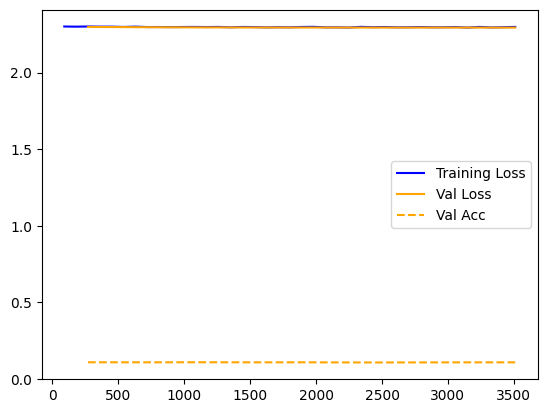

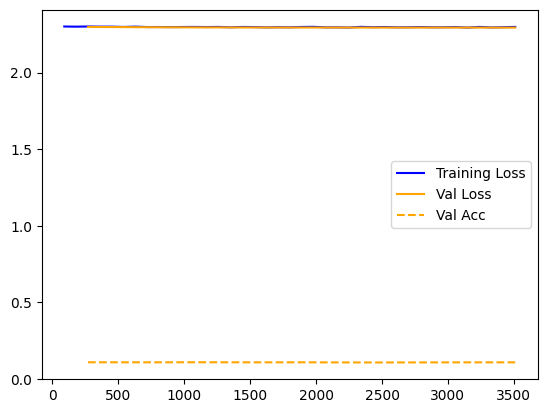

In [35]:
plot_losses(train_loss, train_loss_idx, val_loss, val_acc, val_loss_idx)

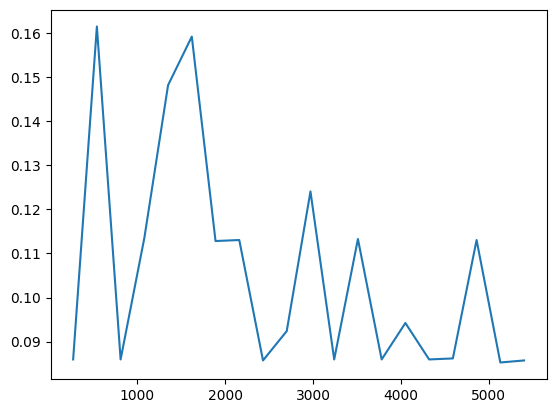

In [72]:
fig, ax = plt.subplots()
ax.plot(val_loss_idx, val_acc)

In [73]:
running_vloss = 0.
running_vacc = 0.
with torch.no_grad():
    for i, vdata in enumerate(val_loader):
        vinputs = vdata['image'].to(device)
        vlabels = vdata['land_use'].to(device)
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss.item()

        vpred = torch.argmax(voutputs, dim=1)
        vacc = (torch.sum(vlabels == vpred) / len(vlabels)).item()
        running_vacc += vacc

In [74]:
running_vloss / (i + 1)

33.95571279525757

In [75]:
running_vacc / len(val_loader)

0.0857077205882353

In [76]:
vacc

0.0625

In [77]:
running_tloss = 0.
running_tacc = 0.
with torch.no_grad():
    for i, vdata in enumerate(test_loader):
        vinputs = vdata['image'].to(device)
        vlabels = vdata['land_use'].to(device)
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_tloss += vloss.item()

        vpred = torch.argmax(voutputs, dim=1)
        vacc = (torch.sum(vlabels == vpred) / len(vlabels)).item()
        running_tacc += vacc

In [78]:
running_tloss / (i + 1)

33.559736184512865

In [79]:
running_tacc / (i + 1)

0.09044117647058823

# Figure out why validation loss is wacky 

In [19]:
sorted(os.listdir(checkpoint_path))

['best_cnn_e0',
 'best_cnn_e1',
 'best_cnn_e1.tar',
 'best_cnn_e2.tar',
 'best_cnn_e5.tar',
 'first_run',
 'latest_cnn_e10',
 'latest_cnn_e10.tar',
 'latest_cnn_e15',
 'latest_cnn_e15.tar',
 'latest_cnn_e19',
 'latest_cnn_e20.tar',
 'latest_cnn_e5']

In [20]:
for model_name in sorted(os.listdir(checkpoint_path)):
    if '.tar' not in model_name:
        continue
    model_path = os.path.join(checkpoint_path, model_name)
    checkpoint_model = Net()
    checkpoint_optim = torch.optim.SGD(checkpoint_model.parameters())
    (model_epoch, checkpoint_optim, _, checkpoint_model, 
     train_loss, train_loss_idx, val_loss, val_acc, val_loss_idx) = load_checkpoint(model_path, checkpoint_model, checkpoint_optim)
    checkpoint_model = checkpoint_model.to(device)

    checkpoint_model.eval()

    print(model_epoch)

    running_tloss = 0.
    with torch.no_grad():
        for i, tdata in enumerate(train_loader):
            tinputs = tdata['image'].to(device)
            tlabels = tdata['land_use'].to(device)
            toutputs = checkpoint_model(tinputs)
            tloss = loss_fn(toutputs, tlabels)
            running_tloss += tloss.item()
    print(f"Average train loss: {running_tloss / (i + 1)}")

    running_vloss = 0.
    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            vinputs = vdata['image'].to(device)
            vlabels = vdata['land_use'].to(device)
            voutputs = checkpoint_model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss.item()
    print(f"Average val loss: {running_vloss / (i + 1)}")
    
    metrics = test_model(test_loader, checkpoint_model)
    print(metrics)

    print('----------------------------------------')

    # TODO: maybe try testing each of the models at different epochs and recalculate their accuracy and val loss?
    

1
Average train loss: 8.448541529973348
Average val loss: 8.432934143963982


100%|██████████| 85/85 [00:21<00:00,  4.03it/s]
/home/bchau/anaconda3/envs/math_156_project/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


           Precision    Recall  F1_Score
Micro Avg   0.090185  0.090185  0.090185
Macro Avg   0.009294  0.100000  0.017007
Accuracy    0.090185       NaN       NaN
----------------------------------------
2
Average train loss: 5.47714815846196
Average val loss: 5.522452494677375


100%|██████████| 85/85 [00:16<00:00,  5.22it/s]
/home/bchau/anaconda3/envs/math_156_project/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


           Precision    Recall  F1_Score
Micro Avg   0.165370  0.165370  0.165370
Macro Avg   0.052485  0.163408  0.074528
Accuracy    0.165370       NaN       NaN
----------------------------------------
5
Average train loss: 4.214392038627907
Average val loss: 4.325993786839878


100%|██████████| 85/85 [00:15<00:00,  5.52it/s]
/home/bchau/anaconda3/envs/math_156_project/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


           Precision    Recall  F1_Score
Micro Avg   0.151111  0.151111  0.151111
Macro Avg   0.206543  0.142075  0.090493
Accuracy    0.151111       NaN       NaN
----------------------------------------
10
Average train loss: 20.80976939731174
Average val loss: 20.926064547370462


100%|██████████| 85/85 [00:15<00:00,  5.32it/s]
/home/bchau/anaconda3/envs/math_156_project/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


           Precision    Recall  F1_Score
Micro Avg   0.095556  0.095556  0.095556
Macro Avg   0.009556  0.100000  0.017444
Accuracy    0.095556       NaN       NaN
----------------------------------------
15
Average train loss: 16.424772781795927
Average val loss: 16.461465372758752


100%|██████████| 85/85 [00:15<00:00,  5.34it/s]
/home/bchau/anaconda3/envs/math_156_project/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


           Precision    Recall  F1_Score
Micro Avg   0.098519  0.098519  0.098519
Macro Avg   0.109588  0.103285  0.023859
Accuracy    0.098519       NaN       NaN
----------------------------------------
20
Average train loss: 33.592857671667026
Average val loss: 33.969872642965875


100%|██████████| 85/85 [00:16<00:00,  5.28it/s]

           Precision    Recall  F1_Score
Micro Avg   0.090185  0.090185  0.090185
Macro Avg   0.009020  0.100000  0.016548
Accuracy    0.090185       NaN       NaN
----------------------------------------



/home/bchau/anaconda3/envs/math_156_project/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
model_path = os.path.join(checkpoint_path, 'latest_cnn_e20.tar')
checkpoint_model = Net()
checkpoint_optim = torch.optim.SGD(checkpoint_model.parameters())
(model_epoch, checkpoint_optim, _, checkpoint_model, 
    train_loss, train_loss_idx, val_loss, val_acc, val_loss_idx) = load_checkpoint(model_path, checkpoint_model, checkpoint_optim)
checkpoint_model = checkpoint_model.to(device)

In [26]:
checkpoint_model = load_checkpoint(model_path, checkpoint_model)
metrics = test_model(test_loader, checkpoint_model)
metrics

100%|██████████| 85/85 [00:17<00:00,  4.97it/s]


,Precision,Recall,F1_Score
Micro Avg,0.768333,0.768333,0.768333
Macro Avg,0.755775,0.760756,0.756312
Accuracy,0.768333,NaN,NaN


In [27]:
checkpoint_model = load_checkpoint(model_path, checkpoint_model)
checkpoint_model.eval()
metrics = test_model(test_loader, checkpoint_model)
metrics

100%|██████████| 85/85 [00:16<00:00,  5.04it/s]
/home/bchau/anaconda3/envs/math_156_project/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Precision,Recall,F1_Score
Micro Avg,0.090185,0.090185,0.090185
Macro Avg,0.009020,0.100000,0.016548
Accuracy,0.090185,NaN,NaN


In [ ]:
# TODO: grid search specific to CNN, googlenet, mobilenet